# CESM-LE analysis
### Looks and changes on rain on snow events over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily FSNO & RAIN
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates

import pandas as pd
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
# For use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18) 
#    to allow dask to allocate more memory to each worker"
ncores = 18
nmem   = str(int(375*ncores/ncores))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='4:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [6]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:34630 Dashboard: http://10.12.205.30/proxy/8787/status,Cluster Workers: 18 Cores: 18 Memory: 374.94 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [7]:
def get_file(ee,model,field,component,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        if yr<=2014:
            mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
        else:
            mlist = sorted(glob.glob(topdir+'*BSSP370cmip6.f09_g17.LE2-13*')) # hack to get SSPs
        mm = mlist[ee]
        atm    = '/atm/proc/tseries/day_1/'
        lnd    = '/lnd/proc/tseries/day_1/'
        firstyear = 10*int(yr/10)
        if yr >= 2015:  # Beause SSPs are 2015-2024...
            firstyear = 10*int(yr/10)+5
        yy    = '.'+str(firstyear)+'0101-'+str(firstyear+9)+'1231.'

        if yr>2009:
            if yr<2014:
                yy = '.20100101-20141231.'
        if yr>=2095:
            yy = '.20950101-21001231.'
        if component == 'lnd': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
        if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
    return ff

In [8]:
def all_files(model,field,firstyear, component,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,component,0) for ee in range(nens)]
    else:
        if firstyear <= 2014:
            yrs = [*np.arange(firstyear,2009,10),2010]
        if firstyear > 2014:
            yrs = [*np.arange((firstyear),2094,10),2095]

        files = [[get_file(ee,'CESM2',field,component,yr) for yr in yrs] 
                 for ee in range(nens)]
        #print(files)
    return files

In [9]:
def get_daily(model,fields,firstyear, component,nens, chunks={'time':500}):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, component,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                # add chunks for time
                ds = xr.open_mfdataset(files[0],combine='by_coords',
                                       parallel=True,chunks=chunks)
                tmp = xr.open_dataset(files[0][0],chunks=chunks)
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0],chunks=chunks)

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks=chunks)
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area']*ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'
        
    ndays = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [10]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Start editing here:

### Actually read in data

In [11]:
%%time

lnd_vars = ['SNOWDP','TSOI'] #RAIN
model = 'CESM2'

combine = True    #logical for reading in full time series
firstyear = 1900
component = 'lnd'
nens = 10  # read in 10 ensemble members for now
dsHIST = get_daily(model,lnd_vars,firstyear, component,nens)
print()

firstyear = 2015
dsSSP = get_daily(model,lnd_vars,firstyear, component,nens)


CPU times: user 14.6 s, sys: 1.06 s, total: 15.7 s
Wall time: 21.5 s


In [12]:
%%time
# subset data to get soil temp at ~10 cm, convet to degC
dsHIST['TSOI'] = (dsHIST['TSOI'].isel(levgrnd=0))#-273.15)#.persist()
dsSSP['TSOI'] = (dsSSP['TSOI'].isel(levgrnd=0))#-273.15)#.persist()

CPU times: user 63.6 ms, sys: 1.02 ms, total: 64.6 ms
Wall time: 63.6 ms


combine full time series, start with single gridcell 

<xarray.DataArray 'TSOI' (ens: 10, time: 73367)>
dask.array<getitem, shape=(10, 73367), dtype=float32, chunksize=(1, 500), chunktype=numpy.ndarray>
Coordinates:
    lon      float32 252.5
    lat      float32 39.11
  * time     (time) object 1900-01-01 00:00:00 ... 2100-12-11 00:00:00
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:     soil temperature (vegetated landunits only)
    units:         K
    cell_methods:  time: mean


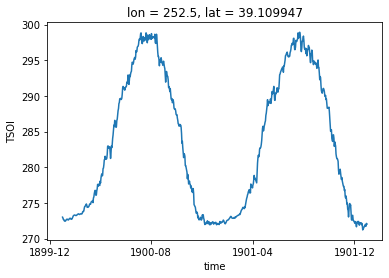

In [13]:
plat, plon = 39,253             # Crested Butte
#plat, plon = 64.8, (360-147.7)   # Fairbanks, AK
combine = True      # logical for reading in full time series
WaterYear = False   # logical for converting time to water year, used below

if combine == True:
    ds = xr.concat([dsHIST[lnd_vars],dsSSP[lnd_vars]],dim='time')
    dsCB = ds.sel(lat = plat, lon = plon, method='nearest')
    dsCB#.persist()#.chunk({'ens':1})
    print(dsCB.TSOI)

dsCB.TSOI.isel(time=slice(0,730)).mean(dim='ens').plot() ;

### Plot ensemble averages for each year period
- Snow depth and soil temperatutres 
- here just for Crested Butte, CO or Fairbanks, AK

In [14]:
%%time
# Compute ensemble statistics
# TODO, this will have to be faster for global results...
#    TSOI calculations are the slow ones...
# Does computing stats make plotting more efficient?

Ycoords = dsCB[lnd_vars[0]].mean(dim=['ens']).coords
Y,    Ystd = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)
Ymin, Ymax = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)


for i in range(len(lnd_vars)):
    print('starting '+ lnd_vars[i])
    Y[lnd_vars[i]]    = dsCB[lnd_vars[i]].mean(dim=['ens']).compute()
    Ystd[lnd_vars[i]] = dsCB[lnd_vars[i]].std(dim=['ens']).persist()
    
    # how to fine the 'appropraite high and low values in each year for each ensemble?  
    # Here just taking the min/max acrros all ensembles'
    #Ymin[lnd_vars[i]] = dsCB[lnd_vars[i]].min(dim=['ens']).persist()
    #Ymax[lnd_vars[i]] = dsCB[lnd_vars[i]].max(dim=['ens']).persist() 

year = np.unique(dsCB['time.year'].values)
print(Y.TSOI)
print(' -- Finished ensemble means -- ')

starting SNOWDP
starting TSOI
<xarray.DataArray 'TSOI' (time: 73367)>
array([272.99384, 272.85858, 272.66934, ..., 273.2338 , 272.89606,
       272.55432], dtype=float32)
Coordinates:
    lat      float32 39.11
    lon      float32 252.5
  * time     (time) object 1900-01-01 00:00:00 ... 2100-12-11 00:00:00
 -- Finished ensemble means -- 
CPU times: user 1min 55s, sys: 6.43 s, total: 2min 2s
Wall time: 24min 36s


In [15]:
%%time     
# quick look to see how to shift days to water year
Y2 = Y.shift(time=-273)
Y2['time'] = Y.time.shift(time=-273)
print(Y2)
#plt.plot(Y2.SNOWDP.isel(time=slice(0,365)) ) ;

<xarray.Dataset>
Dimensions:  (time: 73367)
Coordinates:
    lat      float32 39.11
    lon      float32 252.5
  * time     (time) object 1900-10-01 00:00:00 1900-10-02 00:00:00 ... nan nan
Data variables:
    SNOWDP   (time) float32 1.433e-10 0.0 0.0 3.161e-09 ... nan nan nan nan
    TSOI     (time) float32 287.3 287.4 286.9 286.6 286.1 ... nan nan nan nan
CPU times: user 148 ms, sys: 6.1 ms, total: 154 ms
Wall time: 152 ms


#### Shift results to water year, **just do this once!**
- `WaterYear` protects against doing this multiple times

In [16]:
%%time
if WaterYear == False:
    shift = -273  #starts water year Oct 1
    Y = Y.shift(time=shift)
    Ystd = Ystd.shift(time=shift)
    #Ymin = Ymin.shift(time=shift)
    #Ymax = Ymax.shift(time=shift)

    # shift time coords too
    Y['time'] = Y.time.shift(time=shift)
    Ystd['time'] = Ystd.time.shift(time=shift)
    #Ymin['time'] = Ymin.time.shift(time=shift)
    #Ymax['time'] = Ymax.time.shift(time=shift)
    WaterYear=True

CPU times: user 653 ms, sys: 16.9 ms, total: 670 ms
Wall time: 663 ms


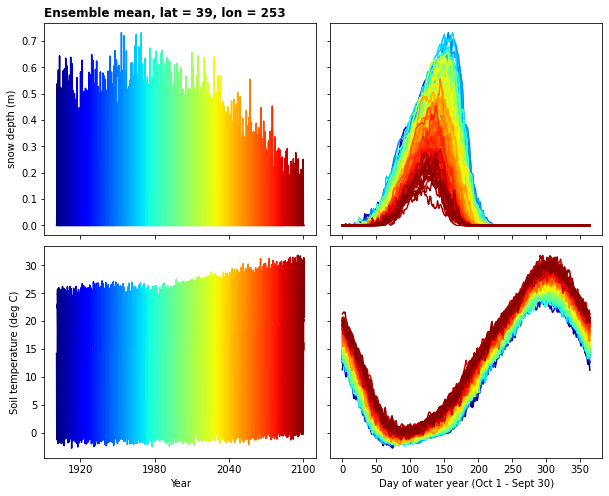

In [17]:
nspan = 1
nyear = int(len(year)/nspan)
color = iter(cm.jet(np.linspace(0,1,nyear)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                                sharey='row', sharex='col',
                                gridspec_kw={'wspace': 0.05, 'hspace':0.05},
                                figsize=(10,8))

for i in range(nyear-1):
    #print(year[(i*nspan)])
    firstDay = 365*nspan*i
    lastDay = firstDay + 365
    x = Y.time.isel(time=slice(firstDay,lastDay))
    y = Y.isel(time=slice(firstDay,lastDay))
    c = next(color)
    ax1.plot(x,y.SNOWDP,c=c) 
    ax2.plot(y.SNOWDP,c=c) 
    ax3.plot(x,y.TSOI-273.15,c=c) 
    ax4.plot(y.TSOI-273.15,c=c) 
    
#months = mdates.MonthLocator((10,11,12,1,2,3,4,5,6,7,8,9))  # every month   
#fmt = mdates.DateFormatter('%b')
#ax.xaxis.set_major_locator(months)
#ax.xaxis.set_major_formatter(fmt)
ax1.set_title('Ensemble mean, lat = '+str(plat)+', lon = '+str(plon), 
              loc='left', fontsize='large', fontweight='bold')
ax1.set_ylabel('snow depth (m)') ;
ax3.set_ylabel('Soil temperature (deg C)') ;
ax3.set_xlabel('Year') ;
ax4.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
#ax.legend(range(year[0],year[-1],nspan), bbox_to_anchor=(1.05, 1), 
#          loc='upper left', borderaxespad=0.01,ncol=2) ;

#### Given chagnes in snowmelt, likley worth looking at runnoff timing & magnitude too
- TODO, add months to x-axis of right plots, starting on Oct-1

In [18]:
#print(y.TSOI)
#plt.plot(y.TSOI)
#print(nyear)

1901
1926
1951
1976
2001
2026
2051
2076


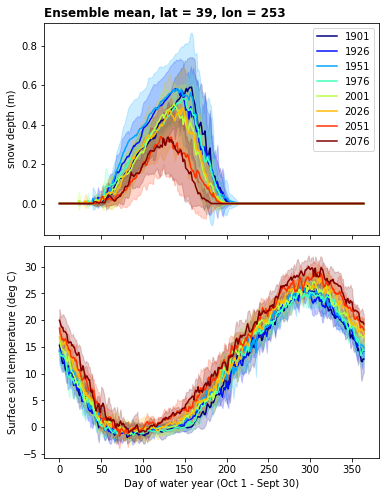

tornado.application - ERROR - Uncaught exception GET /individual-progress/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:8889', method='GET', uri='/individual-progress/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/bokeh/server/views/ws.py", line 125, in open
    raise ProtocolError("Subprotocol header is not 'bokeh'")
bokeh.protocol.exceptions.ProtocolError: Subprotocol header is not 'bokeh'
tornado.application - ERROR - Uncaught exception GET /individual-nbytes/ws (::1)
HTTPServerRequest(protoco

In [19]:
nspan =25
nyear = int(len(year)/nspan)
color = iter(cm.jet(np.linspace(0,1,(nyear))) )

fig, (ax2, ax4) = plt.subplots(2, 1, sharex='col',
                                gridspec_kw={'wspace': 0.05, 'hspace':0.05},
                                figsize=(6,8))

for i in range(nyear):
    print(year[i*nspan]+1)
    firstDay = 365*nspan*i+365
    lastDay = firstDay + 365
    x = Y.time.isel(time=slice(firstDay,lastDay))
    x2 = range(0,365)
    y = Y.isel(time=slice(firstDay,lastDay))
    ystd = Ystd.isel(time=slice(firstDay,lastDay))
    c = next(color)
    # snow depth plots
    #ax1.plot(x,ymin.SNOWDP,c=c) 
    ax2.plot(x2, y.SNOWDP,c=c) 
    ax2.fill_between(x2, y.SNOWDP-ystd.SNOWDP, 
                     y.SNOWDP+ystd.SNOWDP, alpha=0.2,color=c)
    # soil temperature plots
    #ax4.set_ylim(top=8, bottom=-6)
    ax4.plot(x2, y.TSOI-273.15,color=c) 
    ax4.fill_between(x2, y.TSOI+ystd.TSOI-273.15, 
                         y.TSOI-ystd.TSOI-273.15, alpha=0.2,color=c)
    
ax2.set_title('Ensemble mean, lat = '+str(plat)+', lon = '+str(plon), 
              loc='left', fontsize='large', fontweight='bold')
ax2.set_ylabel('snow depth (m)') ;
ax4.set_ylabel('Surface soil temperature (deg C)') ;
ax4.set_xlabel('Day of water year (Oct 1 - Sept 30)') 
ax2.legend(range(year[1],year[-1],nspan), loc='upper right') ;

In [54]:
tsoi = y.TSOI.values
std = ystd.TSOI.values
print(tsoi[1])
print(std[1])
print(Ystd.TSOI.values[0])
print(Y.TSOI.values[0])

2.6385972
2.6385972
1.4389123
1.4389123


In [ ]:
import matplotlib.dates as mdates

# determine the water year
# !! This approach puts Octoberr 1 as DOY=1, but then the previous Jan moves to then end of the year
### try using shift instead?

dsCB['day_water_year'] = xr.where(dsCB.time.dt.dayofyear<=274,dsCB.time.dt.dayofyear+(365-273),dsCB.time.dt.dayofyear-273)
MonthShift = (xr.where(dsCB.time.dt.month<=10,dsCB.time.dt.month+3,dsCB.time.dt.month-9))

plt.figure(figsize=[6,8])

plt.subplot(2,1,1)
plt.plot(dsCB['day_water_year'], dsCB.SNOWDP.mean(dim=['ens']))

plt.subplot(2,1,2)
plt.plot(dsCB['day_water_year'], ds.TSOI.mean(dim=['ens']))

### unsure how to adjust dates for water year (Oct-Sept)
tempTime = pd.date_range('2001-10-01', '2002-09-30', freq='m')
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
print(tempTime)
#X = plt.gca().xaxis
#X.set_major_locator(locator)
# Specify formatter
#X.set_major_formatter(fmt)
plt.show();

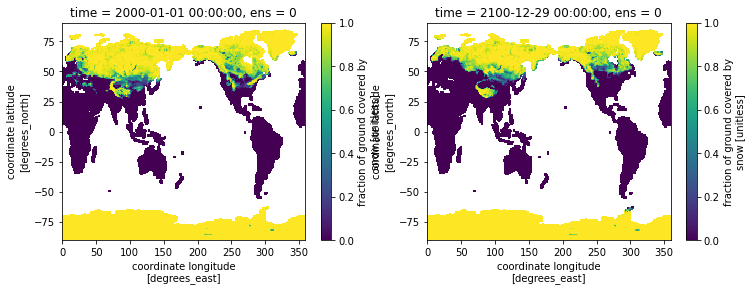

In [25]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
dsHIST[lnd_vars[1]].isel(ens=0,time=0).plot();   
plt.subplot(1,2,2)
dsSSP[lnd_vars[1]].isel(ens=0,time=-1).plot();   

In [26]:
# mask out grids what are always 100% snow covered
dsHIST = dsHIST.where(dsHIST['FSNO'].min(['time','ens'])< 1.)
dsSSP  = dsSSP.where(dsSSP['FSNO'].min(['time','ens'])< 1.)

In [27]:
# for speed, lets just look a single grid cell, here in CO
# maybe avoid loading data into memory, as this seems to kill workers with TSOI data added.

plat, plon = 39,253  #-25, 150
ds = dsHIST.sel(lat=plat,lon=plon, method='nearest')#.load()
ds2 = dsSSP.sel(lat=plat,lon=plon, method='nearest')#.load()

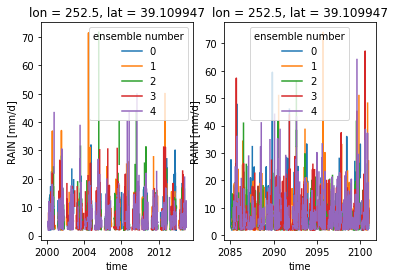

In [28]:
# convert rain to daily flux
s2d = 3600 * 24   # convert seconds to days
ds['RAIN'] = ds.RAIN * s2d
ds2['RAIN'] = ds2.RAIN * s2d
ds['RAIN'].attrs['units'] = 'mm/d'
ds2['RAIN'].attrs['units'] = 'mm/d'

# mask out events < 2 mm day
ds['RAIN'] = ds['RAIN'].where(ds['RAIN']>2)
ds2['RAIN'] = ds2['RAIN'].where(ds2['RAIN']>2)

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
ds.RAIN.plot(hue='ens');
plt.subplot(1,2,2)
ds2.RAIN.plot(hue='ens');

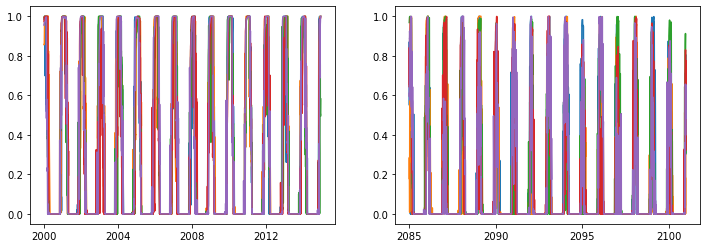

In [29]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
for i in range(nens):
    plt.plot(ds.time,ds.FSNO.isel(ens=i));
plt.subplot(1,2,2)
for i in range(nens):
    plt.plot(ds2.time,ds2.FSNO.isel(ens=i));

### Plot annual averages (across ensembles) for each time period
- snow depth and 
- 10 cm soil temperatutres 

KilledWorker: ("('open_dataset-b1fa1e6305cafd1f5be2be05b02f04beTSOI-259a925a02d44e5e41909949d193fb0b', 0, 0, 0, 0)", <Worker 'tcp://10.12.205.25:43559', name: 0-26, memory: 0, processing: 1>)

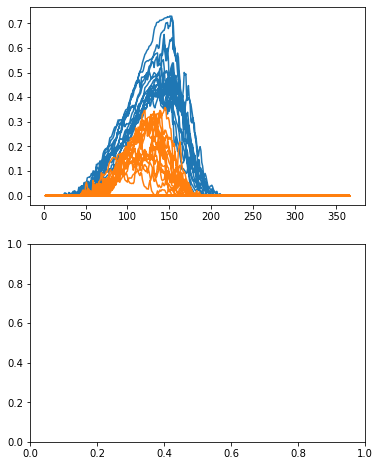

In [30]:
import matplotlib.dates as mdates

# determine the water year
# !! This approach puts Octoberr 1 as DOY=1, but then the previous Jan moves to then end of the year
### try using shift instead?

ds['day_water_year'] = xr.where(ds.time.dt.dayofyear<=274,ds.time.dt.dayofyear+(365-273),ds.time.dt.dayofyear-273)
MonthShift = (xr.where(ds.time.dt.month<=10,ds.time.dt.month+3,ds.time.dt.month-9))
ds2['day_water_year'] = xr.where(ds2.time.dt.dayofyear<=274,ds2.time.dt.dayofyear+(365-273),ds2.time.dt.dayofyear-273)

plt.figure(figsize=[6,8])

plt.subplot(2,1,1)
plt.plot(ds['day_water_year'], ds.SNOWDP.mean(dim=['ens']))
plt.plot(ds2['day_water_year'], ds2.SNOWDP.mean(dim=['ens']))

plt.subplot(2,1,2)
plt.plot(ds['day_water_year'], ds.TSOI.mean(dim=['ens']))
plt.plot(ds2['day_water_year'], ds2.TSOI.mean(dim=['ens']))

### unsure how to adjust dates for water year (Oct-Sept)
tempTime = pd.date_range('2001-10-01', '2002-09-30', freq='m')
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
print(tempTime)
#X = plt.gca().xaxis
#X.set_major_locator(locator)
# Specify formatter
#X.set_major_formatter(fmt)
plt.show();

### Calculate number of rain on snow days...

<xarray.DataArray 'time' ()>
array(cftime.DatetimeGregorian(2010, 1, 11, 0, 0, 0, 0), dtype=object)
Coordinates:
    lon      float32 252.5
    lat      float32 39.11
    time     object 2010-01-11 00:00:00


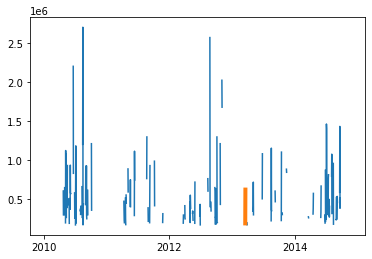

In [193]:
minFSNO = 0.4
minSNOWDP = 0.1
ds['RAINonSNOW'] = ds.RAIN.where(ds.FSNO>minFSNO)
ds2['RAINonSNOW'] = ds2.RAIN.where(ds2.FSNO>minFSNO)
#ds['RAINonSNOW'] = ds.RAIN.where(ds.SNOWDP>minSNOWDP)
plt.plot(ds.time,ds['RAIN'].isel(ens=2))
plt.plot(ds.time,ds['RAINonSNOW'].isel(ens=2),lw=4);

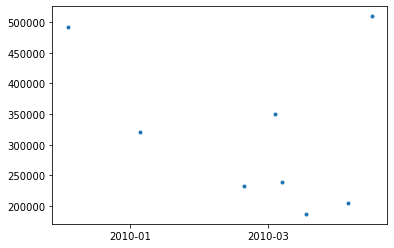

In [194]:
plt.plot(ds['time'].isel(time=slice(0,365)), ds['RAINonSNOW'].isel(ens=2,time=slice(0,365)),'.' );

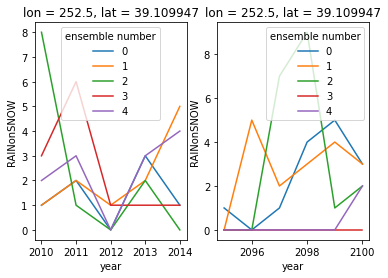

In [195]:
RS_yearHIST = ds['RAINonSNOW'].groupby('time.year').count(dim='time')
RS_yearSSP = ds2['RAINonSNOW'].groupby('time.year').count(dim='time')
plt.subplot(1,2,1)
RS_yearHIST.plot(hue='ens');
plt.subplot(1,2,2)
RS_yearSSP.plot(hue='ens');

In [141]:
print(RS_year.mean(dim='ens'))

<xarray.DataArray 'RAINonSNOW' (year: 5)>
array([3. , 2.8, 0.4, 2.2, 2.2])
Coordinates:
    lon      float32 252.5
    lat      float32 39.11
  * year     (year) int64 2010 2011 2012 2013 2014


CPU times: user 27.8 ms, sys: 1.99 ms, total: 29.8 ms
Wall time: 28.6 ms


Text(0, 0.5, 'acc_NI')

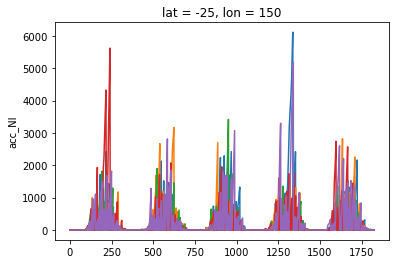

In [38]:
%%time 
# reset cumulative sum when nan crossed in dataset
# pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan seems to work, 
#    not so much for the numpy example...

# select single grid cell
for i in range(nens):
    ## if single point already selected
    v = pd.Series(ds['d_NI'].isel(ens=i).values)
    
    # or to look at a single point here
    plat, plon = -25, 150
    #v = pd.Series(ds['d_NI'].sel(lat=plat,lon=plon, method='nearest').isel(ens=i).values)

    # Then continue with pandas cumsum example 
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()

    plt.plot(result)

plt.title('lat = '+str(plat)+', lon = '+str(plon))
plt.ylabel('acc_NI');

Time isn't being handled correctly for some reason...

How does this get built out efficiently in xarray?  
- likely need to use ufunc

## Fire Risk classification
* 0-300 minimal danger
* to 1000 moderate
* to 4000 high
* above 4000 extreme


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1821   NaN
1822   NaN
1823   NaN
1824   NaN
1825   NaN
Length: 1826, dtype: float32


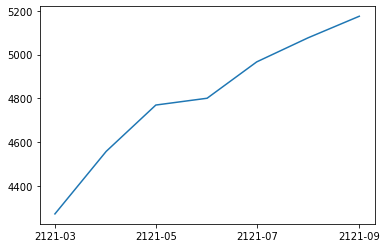

In [42]:
ex = result.where(result>4000)
print(ex)
plt.plot(ds.time,ex);
# eventaully could calculate the number of days / year where fire risk is moderate, high, extreme & compare change over time

### Sanity check, look at daily and accumulated NI for single ensemble member

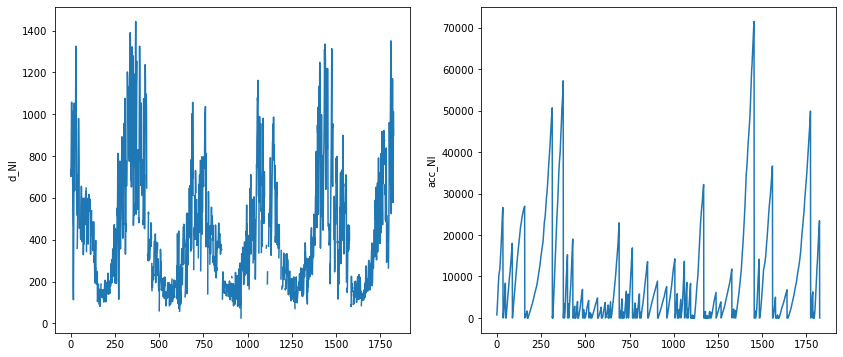

In [24]:
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.plot(v)
plt.ylabel('d_NI')
plt.subplot(1,2,2)
plt.plot(result)
plt.ylabel('acc_NI');

In [ ]:
print(ds.time['time'])

In [25]:
ds['d_NI'].isel(time=0,ens=0).plot()

KilledWorker: ("('where-getitem-6badac1209ef9884dd3066bfb93a482b', 0, 0)", <Worker 'tcp://10.12.205.31:43743', name: 0-9, memory: 0, processing: 1>)

In [37]:
print(v)

NameError: name 'v' is not defined